In [1]:
# !pip install tensorflow==2.8.0
!pip install efficientnet
!pip install --upgrade wandb
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.15.5
    Uninstalling wandb-0.15.5:
      Successfully uninstalled wandb-0.15.5


In [2]:
import os
import re
import random
import pandas as pd
import numpy as np
import json
import math
import string
import uuid


### Tensorflow Imports
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Layer, \
                        UpSampling1D, Input, DepthwiseConv2D, Conv2D, \
                        BatchNormalization, ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras.applications import MobileNet


### External models
import efficientnet.tfkeras as efn


### Matplotlib Imports
import matplotlib
import matplotlib.pyplot as plt


### import wandb
import wandb
from wandb.keras import WandbCallback

### Kaggle specific imports
if os.environ.get('KAGGLE_DOCKER_IMAGE', None):
    from kaggle_datasets import KaggleDatasets
    DATA_PATH = KaggleDatasets().get_gcs_path()
    DATA_PATH = DATA_PATH + '/mitdb128x128'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
import boto3
import os
from botocore import UNSIGNED
from botocore.config import Config


def download_files(bucket_name, s3_prefix, local_directory):
    s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
    bucket = s3.Bucket(bucket_name)

    for obj in bucket.objects.filter(Prefix=s3_prefix):
        local_file = os.path.join(local_directory, obj.key)

        if not os.path.exists(os.path.dirname(local_file)):
            os.makedirs(os.path.dirname(local_file))

        bucket.download_file(obj.key, local_file)
        print(f"Downloaded {obj.key} to {local_file}")

download_files('mitdb128x128', 'train', '/content/input')

Downloaded trainfile_class10_fold0_6117.tfrec to /content/input/trainfile_class10_fold0_6117.tfrec
Downloaded trainfile_class10_fold1_6116.tfrec to /content/input/trainfile_class10_fold1_6116.tfrec
Downloaded trainfile_class10_fold2_6116.tfrec to /content/input/trainfile_class10_fold2_6116.tfrec
Downloaded trainfile_class10_fold3_6116.tfrec to /content/input/trainfile_class10_fold3_6116.tfrec
Downloaded trainfile_class10_fold4_6116.tfrec to /content/input/trainfile_class10_fold4_6116.tfrec
Downloaded trainfile_class10_fold5_6116.tfrec to /content/input/trainfile_class10_fold5_6116.tfrec
Downloaded trainfile_class10_fold6_6116.tfrec to /content/input/trainfile_class10_fold6_6116.tfrec
Downloaded trainfile_class10_fold7_6117.tfrec to /content/input/trainfile_class10_fold7_6117.tfrec
Downloaded trainfile_class10_fold8_6116.tfrec to /content/input/trainfile_class10_fold8_6116.tfrec
Downloaded trainfile_class10_fold9_6116.tfrec to /content/input/trainfile_class10_fold9_6116.tfrec


In [4]:
hparams = {
    "backbone" : "b0",
    "batch_size" : 32,
    "epochs" : 40,
    "img_size" : 128,
    "lr" : 0.01,
    "optimizer" : "adam",
    "seed": 257
}

In [5]:
class WandBConfigurations():
    def __init__(self, exp_name = "ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS"):
        self.EXPERIMENT_NAME = exp_name
        os.environ["WANDB_API_KEY"] = "221507f411c2ddcc0c17238e115a12c528a482f6"
        wandb.login()

WB = WandBConfigurations()

wandb: Currently logged in as: shreya-srivas02. Use `wandb login --relogin` to force relogin


In [6]:
 class Utils():
    def __init__(self):
        self.seed_everything()

    def id_generator(size=6):
        return str(uuid.uuid4())[:size]

    def setupTPU(self):

        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            print('Running on TPU ', tpu.cluster_spec().as_dict())
        except ValueError:
            tpu = None

        if tpu:
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)
            STRATEGY = strategy
            BATCH_SIZE = 8 * strategy.num_replicas_in_sync
            # wandb.config.hardware = 'TPU'
        else:
            strategy = tf.distribute.get_strategy()
            
        return strategy

    def seed_everything(self):
        np.random.seed(hparams['seed'])
        tf.random.set_seed(hparams['seed'])
        random.seed(a=hparams['seed'])
        os.environ['PYTHONHASHSEED'] = str(hparams['seed'])

UTILS = Utils()
STRATEGY = UTILS.setupTPU()

In [7]:
STRATEGY

In [8]:
class Config():
    def __init__(self):
        self.DO_VAL_SPLIT = True
        self.TRAIN_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[:-1]
        self.TOTAL_TRAIN_IMG = 48929
        self.TOTAL_VAL_IMG = 6116
        self.TOTAL_TEST_IMG = 6116
        self.BACKBONE = hparams['backbone']
        self.IMG_TRAIN_SHAPE = [hparams["img_size"],hparams["img_size"]]
        self.DO_FINETUNE = True
        self.BATCH_SIZE = hparams["batch_size"] # 16
        self.EPOCHES = hparams["epochs"]
        self.SEED = hparams["seed"]
        self.LOSS = tf.keras.losses.CategoricalCrossentropy()
        self.OPTIMIZER = self.get_optimizer()
        self.ACCURACY = []
        self.CALLBACKS = []
        self.STRATEGY = STRATEGY
        self.FOLDS = 9
        self.USE_LR_SCHEDULER = True
        self.FOLD_NUMBER = 0
        self.FOLDS_DICT = {}

        if self.USE_LR_SCHEDULER:
            lrfn = self.get_cosine_schedule_with_warmup(lr=hparams['lr'])
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)
            self.CALLBACKS.append(lr_schedule)

    def get_optimizer(self):
        if hparams['optimizer'] == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'rmsprop':
            return tf.keras.optimizers.RMSprop(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adagrad':
            return tf.keras.optimizers.Adagrad(learning_rate=hparams["lr"])
        if hparams['optimizer'] == 'adadelta':
            return tf.keras.optimizers.Adadelta(learning_rate=hparams["lr"])

        return tf.keras.optimizers.Adam(learning_rate=hparams["lr"])

    def get_cosine_schedule_with_warmup(
        self,
        lr = 0.00004,
        num_warmup_steps = 0,
        num_cycles=0.5):
        num_training_steps = self.EPOCHES
        def lrfn(epoch):
            if epoch < num_warmup_steps:
                return (float(epoch) / float(max(5, num_warmup_steps))) * lr
            progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

        return lrfn


CONFIG = Config()

In [9]:
CONFIG.TRAIN_FILES

['/content/input/trainfile_class10_fold0_6117.tfrec',
 '/content/input/trainfile_class10_fold1_6116.tfrec',
 '/content/input/trainfile_class10_fold2_6116.tfrec',
 '/content/input/trainfile_class10_fold3_6116.tfrec',
 '/content/input/trainfile_class10_fold4_6116.tfrec',
 '/content/input/trainfile_class10_fold5_6116.tfrec',
 '/content/input/trainfile_class10_fold6_6116.tfrec',
 '/content/input/trainfile_class10_fold7_6117.tfrec',
 '/content/input/trainfile_class10_fold8_6116.tfrec']

In [10]:
class Data():
    def __init__(self):
        self.LABELED_TFREC_FORMAT = {
            "image_id": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            'target10': tf.io.FixedLenFeature([], tf.int64),
            'gender' : tf.io.FixedLenFeature([], tf.int64),
            'age_interval' : tf.io.FixedLenFeature([], tf.int64),
        }

    def process_training_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10 }

    def process_testing_data(self, data_file):
        data = tf.io.parse_single_example(data_file, self.LABELED_TFREC_FORMAT)
        img = tf.image.decode_jpeg(data['image'], channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*CONFIG.IMG_TRAIN_SHAPE, 1])

        age = tf.cast(data['age_interval'], tf.float32) / 10.0
        sex = tf.cast(data['gender'], tf.float32) / 1.0
        tab_data = [tf.cast(tfeat, dtype = tf.float32) for tfeat in [age, sex]]
        tabular_data = tf.stack(tab_data)

        target10 = tf.one_hot(data['target10'], depth=10)
        image_id = data["image_id"]

        return {'inp1' : img, 'inp2' : tabular_data}, {"target10" : target10, "image_id":  data['image_id']}

    def val_dataset(self):
        ignore_order = tf.data.Options()
        val_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(CONFIG.FOLD_NUMBER)]["valfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return val_dataset

    def train_dataset(self):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        train_dataset = (
            tf.data.TFRecordDataset(
                CONFIG.FOLDS_DICT["fold_{}".format(fold_number)]["trainfiles"],
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_training_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).repeat(
            ).shuffle(
                CONFIG.SEED
            ).batch(
                CONFIG.BATCH_SIZE
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )

        return train_dataset

    def test_dataset(self):
        ignore_order = tf.data.Options()
        TEST_FILES = sorted(tf.io.gfile.glob('/content/input/train*.tfrec'))[-1]
        test_dataset = (
            tf.data.TFRecordDataset(
                TEST_FILES,
                num_parallel_reads=tf.data.experimental.AUTOTUNE
            ).with_options(
                ignore_order
            ).map(
                self.process_testing_data,
                num_parallel_calls=tf.data.experimental.AUTOTUNE
            ).batch(
                CONFIG.BATCH_SIZE *  4
            ).prefetch(
                tf.data.experimental.AUTOTUNE
            )
        )
        return test_dataset


In [11]:
import wandb
run = wandb.init()
artifact = run.use_artifact('shreya-srivas02/ECG_BEAT_CLASSIFICATION_PAPER_COMMENTS/model-whole-jazz-161:v13', type='model')
artifact_dir = artifact.download()



# model_till_last_epoch = model
# SAVED_MODEL_LOC = "model-0.h5"
# model = rECGnition()
# model.load_weights(SAVED_MODEL_LOC)

wandb:   5 of 5 files downloaded.  


In [21]:
new_model = tf.keras.models.load_model('/kaggle/working/artifacts/model-whole-jazz-161:v13')

In [22]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 32)   320         ['inp1[0][0]']                   
                                                                                                  
 conv2d_51 (Conv2D)             (None, 64, 64, 32)   832         ['inp1[0][0]']                   
                                                                                                  
 batch_normalization_69 (BatchN  (None, 64, 64, 32)  128         ['conv2d_50[0][0]']        

In [23]:
new_model.layers[5].ouputs

AttributeError: 'ReLU' object has no attribute 'ouputs'

In [56]:
XX = new_model.input 
YY = new_model.layers[5].output
new_model_conv1 = tf.keras.models.Model(XX, YY)

In [57]:
YY = new_model.layers[6].output
new_model_conv2 = tf.keras.models.Model(XX, YY)

In [58]:
DATA = Data()
test_dataset = DATA.test_dataset().map(lambda data, ids: data)

In [60]:
predict_conv1 = new_model_conv1.predict(next(iter(test_dataset)))
predict_conv2 = new_model_conv2.predict(next(iter(test_dataset)))

4/4 [==============================] - 0s 3ms/step


In [52]:
predict[38].shape

(64, 64, 32)

In [53]:
predict[38][:,:,1].shape

(64, 64)

In [89]:
test_dataset = DATA.test_dataset().map(lambda data, ids: data)

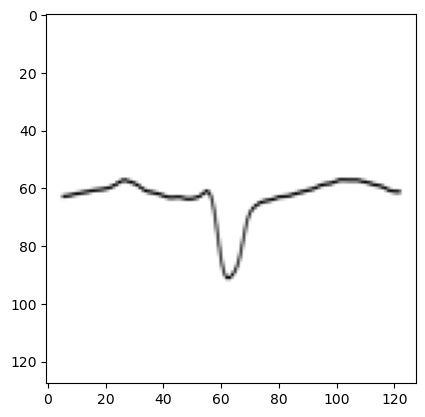

In [93]:
plt.imshow(next(iter(test_dataset))['inp1'].numpy()[13], cmap='gray')

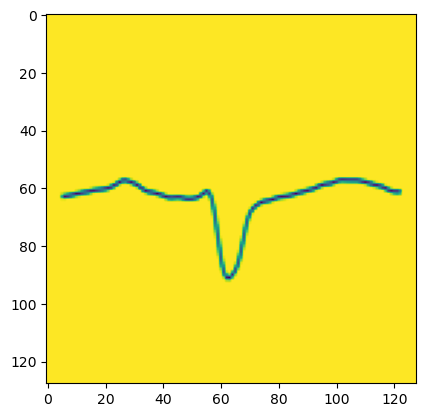

In [92]:
plt.imshow(next(iter(test_dataset))['inp1'].numpy()[13])

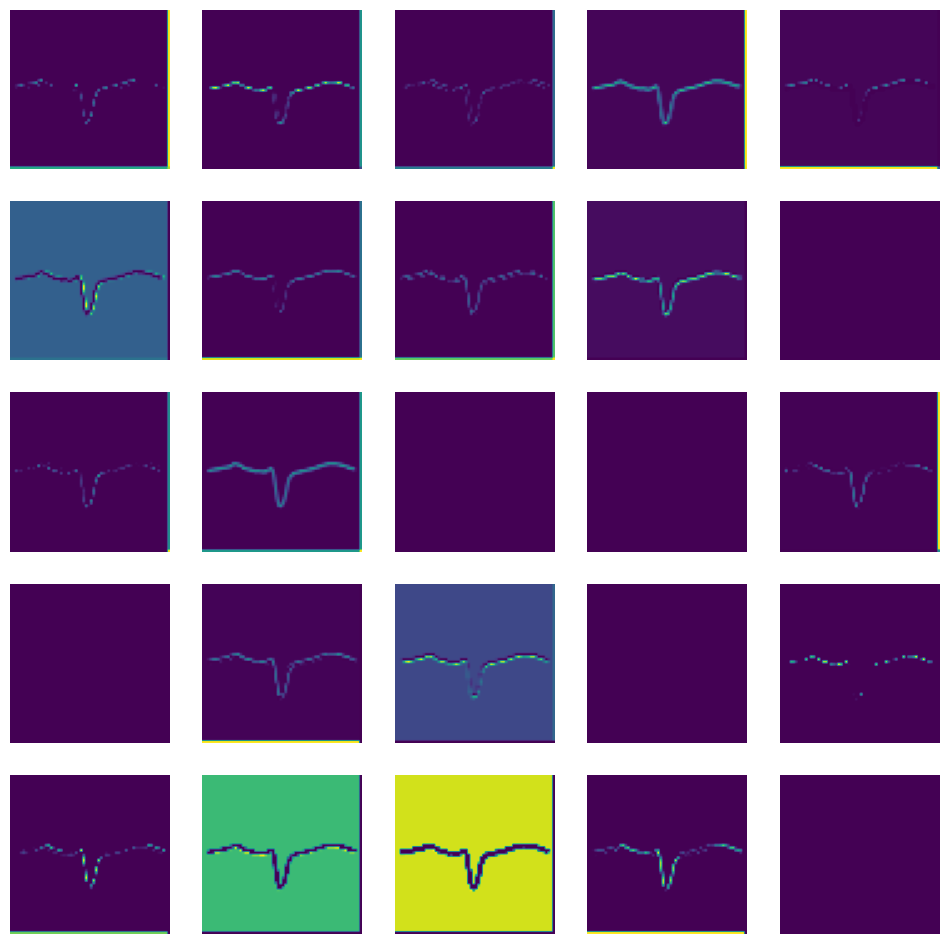

In [87]:
f, axarr = plt.subplots(5,5, figsize=(12, 12))
faxes = axarr.flatten()
for i, ax in enumerate(faxes):
    ax.imshow(predict_conv1[13][:,:,i])
    ax.set_axis_off()

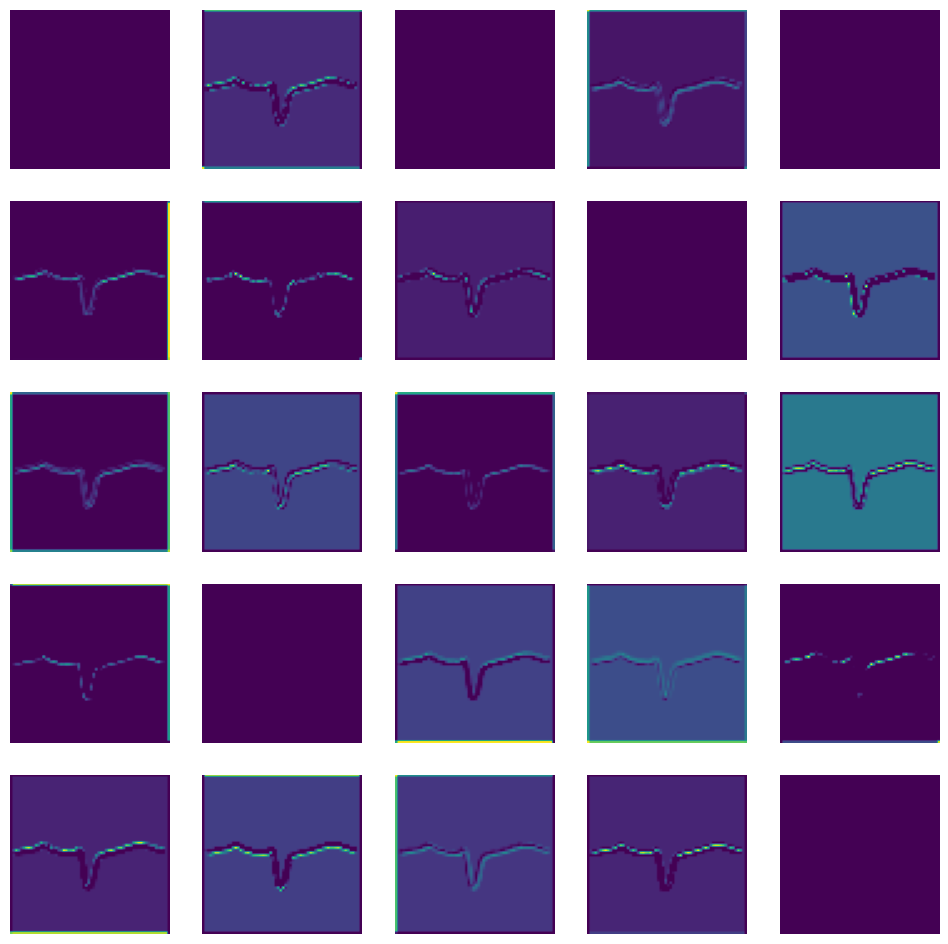

In [88]:
f, axarr = plt.subplots(5,5, figsize=(12, 12))
faxes = axarr.flatten()
for i, ax in enumerate(faxes):
    ax.imshow(predict_conv2[13][:,:,i])
    ax.set_axis_off()